## 2. Network analysis [RUN ONLY FOR 01-01-2020]

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
#pyspark --packages graphframes:graphframes:0.8.1-spark2.4-s_2.12
conf = pyspark.SparkConf().setAll([('spark.jars', 'gs://spark-lib/bigquery/spark-bigquery-latest_2.12.jar'),
                                   ('spark.jars.packages', 'graphframes:graphframes:0.8.1-spark2.4-s_2.12')])

spark = SparkSession.builder \
    .master('yarn') \
    .appName('spark-bigquery-crypto') \
    .config(conf = conf) \
    .getOrCreate()

spark

In [3]:
bucket = "dataproc-staging-us-central1-397709471406-lrrymuq9"
spark.conf.set('temporaryGcsBucket', bucket)

In [4]:
from graphframes import *

In [18]:
# Load data from BigQuery.
table = 'charged-sector-315517:ethereum_onchain.transactions'

# .option("filter", "DATE(block_timestamp) between '2020-01-01' and '2020-01-31'") \
eth_transactions = spark.read.format('bigquery') \
                          .option('table', table) \
                          .option("filter", "DATE(block_timestamp) = '2020-01-01'") \
                          .load()

eth_transactions.createOrReplaceTempView('eth_transactions')

In [19]:
edges = spark.sql('''
                    SELECT from_address as src, to_address as dst, value, block_timestamp, `hash` hash_trnsct
                    FROM eth_transactions
                    where from_address is not null and to_address is not null
                    --and DATE(block_timestamp) = '2020-01-01'
                    ''')

In [20]:
nodes = edges \
         .select("src") \
         .union(edges.select("dst")) \
         .distinct() \
         .withColumnRenamed('src', 'id')

In [21]:
nodes.show(2)

+--------------------+
|                  id|
+--------------------+
|0x0d86a7a059f316f...|
|0x7238223d1baa660...|
+--------------------+
only showing top 2 rows



In [22]:
edges.show(2)

+--------------------+--------------------+-----+-------------------+--------------------+
|                 src|                 dst|value|    block_timestamp|         hash_trnsct|
+--------------------+--------------------+-----+-------------------+--------------------+
|0x00472c1e4275230...|0xcd111aa492a9c77...| 0E-9|2020-01-01 02:08:52|0x5f10a5daa31cb78...|
|0x00472c1e4275230...|0xcd111aa492a9c77...| 0E-9|2020-01-01 06:21:38|0x90e16e94bb357cf...|
+--------------------+--------------------+-----+-------------------+--------------------+
only showing top 2 rows



In [23]:
g = GraphFrame(nodes, edges)

### Degrees distributions

In [35]:
%%time
gDegrees = g.inDegrees.join(g.outDegrees, 'id', 'outer').na.fill(0)
gDegrees.sort(F.desc("inDegree")).show(5, False)
gDegrees.sort(F.desc("outDegree")).show(5, False)

+------------------------------------------+--------+---------+
|id                                        |inDegree|outDegree|
+------------------------------------------+--------+---------+
|0xdac17f958d2ee523a2206206994597c13d831ec7|48981   |0        |
|0x68e54af74b22acaccffa04ccaad13be16ed14eac|8517    |0        |
|0xcadb96858fe496bb6309622f9023ba2defb5d540|8340    |0        |
|0x8fdcc30eda7e94f1c12ce0280df6cd531e8365c5|6859    |0        |
|0x06012c8cf97bead5deae237070f9587f8e7a266d|5291    |0        |
+------------------------------------------+--------+---------+
only showing top 5 rows

+------------------------------------------+--------+---------+
|id                                        |inDegree|outDegree|
+------------------------------------------+--------+---------+
|0xea674fdde714fd979de3edf0f56aa9716b898ec8|0       |12060    |
|0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5|0       |4814     |
|0x84295d5e054d8cff5a22428b195f5a1615bd644f|0       |4357     |
|0x8babf0ba311a

In [36]:
%%time
gDegrees.drop("id").describe().show()

+-------+------------------+------------------+
|summary|          inDegree|         outDegree|
+-------+------------------+------------------+
|  count|            159279|            159279|
|   mean|2.9224756559245098|2.9224756559245098|
| stddev|136.58425654668912|52.896254157525966|
|    min|                 0|                 0|
|    max|             48981|             12060|
+-------+------------------+------------------+

CPU times: user 3.43 ms, sys: 713 µs, total: 4.14 ms
Wall time: 4.59 s


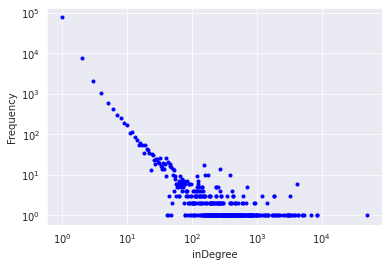

CPU times: user 1.14 s, sys: 23.9 ms, total: 1.17 s
Wall time: 6.66 s


In [40]:
%%time
log_count_list = [x['count'] for x in g.inDegrees.drop("id").groupBy("inDegree").count().select('count').collect()]
log_inDegree_list = [x['inDegree'] for x in g.inDegrees.drop("id").groupBy("inDegree").count().select('inDegree').collect()]

fig, ax = plt.subplots()
plt.plot(log_inDegree_list, log_count_list, 'b.')
plt.ylabel('Frequency')
plt.xlabel('inDegree')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

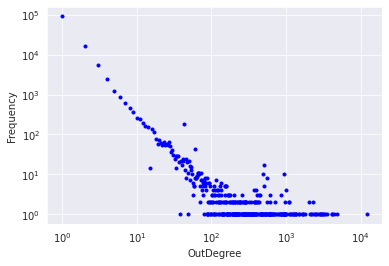

CPU times: user 926 ms, sys: 0 ns, total: 926 ms
Wall time: 6.28 s


In [41]:
%%time
log_count_list = [x['count'] for x in g.outDegrees.drop("id").groupBy("outDegree").count().select('count').collect()]
log_outDegree_list = [x['outDegree'] for x in g.outDegrees.drop("id").groupBy("outDegree").count().select('outDegree').collect()]


fig, ax = plt.subplots()
plt.plot(log_outDegree_list, log_count_list, 'b.')
plt.ylabel('Frequency')
plt.xlabel('OutDegree')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

### PageRank

In [34]:
%%time
# Run PageRank algorithm and show top 10 results.
results = g.pageRank(resetProbability=0.1, maxIter=10)
results.vertices.select("id", "pagerank").sort(F.desc("pagerank")).show(10, False)

+------------------------------------------+------------------+
|id                                        |pagerank          |
+------------------------------------------+------------------+
|0xdac17f958d2ee523a2206206994597c13d831ec7|8871.21936128007  |
|0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be|1470.7253331038562|
|0x5e07b6f1b98a11f7e04e7ffa8707b63f1c177753|1463.9912669229016|
|0x68e54af74b22acaccffa04ccaad13be16ed14eac|1437.0096557882616|
|0xcfcf469b76113c5e7218f8275eaf10a881ac106d|1181.9322675161513|
|0xcadb96858fe496bb6309622f9023ba2defb5d540|759.1644792166619 |
|0xd7cc16500d0b0ac3d0ba156a584865a43b0b0050|714.6486228622971 |
|0xbcf935d206ca32929e1b887a07ed240f0d8ccd22|684.3307191834742 |
|0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48|559.1603035104554 |
|0x2b591e99afe9f32eaa6214f7b7629768c40eeb39|516.1284156281846 |
+------------------------------------------+------------------+
only showing top 10 rows

CPU times: user 51.5 ms, sys: 9.45 ms, total: 61 ms
Wall time: 4min 41s


### Motifs

In [32]:
%%time
# Count pairs of vertices with edges in both directions between them.
motifs = g.find("(a)-[e]->(b); (b)-[e2]->(a)")
motifs.show(5)

+--------------------+--------------------+--------------------+--------------------+
|                   a|                   e|                   b|                  e2|
+--------------------+--------------------+--------------------+--------------------+
|[0xd7a8ddd1ff0fe8...|[0xd7a8ddd1ff0fe8...|[0x76f0fb9c5cfe95...|[0x76f0fb9c5cfe95...|
|[0xcae9cd51a1e816...|[0xcae9cd51a1e816...|[0xc2c21fcdea61ad...|[0xc2c21fcdea61ad...|
|[0xcae9cd51a1e816...|[0xcae9cd51a1e816...|[0xc2c21fcdea61ad...|[0xc2c21fcdea61ad...|
|[0x54c666e8e09ab4...|[0x54c666e8e09ab4...|[0xc2fb36db76571a...|[0xc2fb36db76571a...|
|[0x54c666e8e09ab4...|[0x54c666e8e09ab4...|[0xc2fb36db76571a...|[0xc2fb36db76571a...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

CPU times: user 2.01 ms, sys: 3.9 ms, total: 5.91 ms
Wall time: 18.8 s


In [ ]:
%%time
triangles = g.triangleCount()
triangles.select("id", "count").sort(F.desc("count")).show(5, False)

+------------------------------------------+-----+
|id                                        |count|
+------------------------------------------+-----+
|0xdac17f958d2ee523a2206206994597c13d831ec7|3255 |
|0x1091c132630310aca62f62cb155f2506070c2ec5|1070 |
|0xd78e0d77f0801c22561deaa5e958667fc590973f|1070 |
|0x29d5b3c621606fc8b1a76395f3cc091dd7fb5152|701  |
|0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be|471  |
+------------------------------------------+-----+
only showing top 5 rows

CPU times: user 28.8 ms, sys: 33.6 ms, total: 62.4 ms
Wall time: 4min 49s


### Connected components
https://en.wikipedia.org/wiki/Component_(graph_theory)

In [24]:
sc = spark.sparkContext
sc.setCheckpointDir('graphframes_cps')

In [28]:
%%time
conncomp = g.connectedComponents()
conncomp.select("id", "component").sort(F.desc("component")).show(5, False)

+------------------------------------------+-------------+
|id                                        |component    |
+------------------------------------------+-------------+
|0xa1380417ea4721b69c36a747da16ccf96ef984b9|1709396984323|
|0x05947d13b2b7a86a0b8fa83e8641050b87d73b2b|1709396983830|
|0xc86f6dbbf283b79c89d18bbd69f89f21deddce3e|1683627180652|
|0xc3fa2be82e7e7124fa6f75c22bec0119683a0265|1683627180652|
|0x50e9bd47939b996439d00b40a66a05378c6e0c41|1675037245656|
+------------------------------------------+-------------+
only showing top 5 rows

CPU times: user 16 ms, sys: 4.89 ms, total: 20.9 ms
Wall time: 1min 14s


### Strongly connected components

https://en.wikipedia.org/wiki/Strongly_connected_component

In [ ]:
%%time
strconncomp = g.stronglyConnectedComponents(maxIter=10)
strconncomp.select("id", "component").sort(F.desc("component")).show(5, False)

### Label Propagation Algorithm (LPA)
https://en.wikipedia.org/wiki/Label_propagation_algorithm

In [ ]:
%%time
labprop = g.labelPropagation(maxIter=5)
labprop.select("id", "label").show(5, False)